In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
url = "http://books.toscrape.com/"

# Siteye isteği gönderiyoruz
response = requests.get(url)

# Bağlantı başarılı mı? (200 görmeliyiz)
print(f"Status Code: {response.status_code}")

# HTML içeriğini 'Soup' formatına çeviriyoruz ki içinde arama yapabilelim
soup = BeautifulSoup(response.content, "html.parser")

Status Code: 200


In [3]:
type(soup)

bs4.BeautifulSoup

In [4]:
# Sayfadaki "product_pod" sınıfına sahip tüm "article" etiketlerini buluyoruz
books_html = soup.find_all("article", class_="product_pod")

# Kaç tane bulduğumuzu kontrol edelim (20 çıkmalı)
len(books_html)

20

In [5]:
# İlk kitabın HTML kodunu görelim
first_book = books_html[0]
first_book

<article class="product_pod">
<div class="image_container">
<a href="catalogue/a-light-in-the-attic_1000/index.html"><img alt="A Light in the Attic" class="thumbnail" src="media/cache/2c/da/2cdad67c44b002e7ead0cc35693c0e8b.jpg"/></a>
</div>
<p class="star-rating Three">
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
</p>
<h3><a href="catalogue/a-light-in-the-attic_1000/index.html" title="A Light in the Attic">A Light in the ...</a></h3>
<div class="product_price">
<p class="price_color">£51.77</p>
<p class="instock availability">
<i class="icon-ok"></i>
    
        In stock
    
</p>
<form>
<button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>
</form>
</div>
</article>

In [6]:
# Başlık h3 -> a etiketinin 'title' özelliğinde saklı
book_title = first_book.find("h3").find("a").attrs["title"]
book_title

'A Light in the Attic'

In [7]:
# Fiyatı buluyoruz
price_text = first_book.find("p", class_="price_color").string

# Başındaki '£' işaretini atıp (string slicing) sayıya çeviriyoruz
book_price = float(price_text[1:])
book_price

51.77

In [8]:
# Yıldız bilgisini içeren sınıf listesini alalım
book_stars = first_book.find("p", class_="star-rating").attrs['class']
book_stars

['star-rating', 'Three']

In [9]:
def parse_rating(rating_classes):
    # İngilizce sayıları rakama çeviren sözlük
    ratings = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
    
    # Listede bu kelimelerden hangisi varsa onun sayısını döndür
    for rating in ratings:
        if rating in rating_classes:
            return ratings[rating]
    return 0

In [10]:
# Fonksiyonu çağırıyoruz
book_rating = parse_rating(book_stars)
print(f"Yıldız Sayısı: {book_rating}")

Yıldız Sayısı: 3


In [11]:
# Verileri saklayacağımız boş sözlük
books_dict = { 'Title': [], 'Price': [], 'Rating': [] }

# Sayfadaki her bir kitap için dönüyoruz
for book in books_html:
    # 1. Başlığı al
    title = book.find("h3").find("a").attrs["title"]
    
    # 2. Fiyatı al ve temizle (£ işaretini at, float yap)
    price = float(book.find("p", class_="price_color").text[1:])
    
    # 3. Yıldızı al ve sayıya çevir (fonksiyonumuzu kullanıyoruz)
    rating = parse_rating(book.find("p", class_="star-rating").attrs['class'])
    
    # 4. Listelere ekle
    books_dict["Title"].append(title)
    books_dict["Price"].append(price)
    books_dict["Rating"].append(rating)

# İşlem bittiğinde kaç kitap topladığımızı görelim
len(books_dict["Title"])

20

In [12]:
# Sözlüğü DataFrame'e çeviriyoruz
books_df = pd.DataFrame(books_dict)

# İlk 5 satırı görelim
books_df.head()

,Title,Price,Rating
0,A Light in the Attic,51.77,3
1,Tipping the Velvet,53.74,1
2,Soumission,50.10,1
3,Sharp Objects,47.82,4
4,Sapiens: A Brief History of Humankind,54.23,5


In [13]:
# Tüm verileri tutacak büyük sepetimiz
all_books_dict = { 'Title': [], 'Price': [], 'Rating': [] }

# 1'den 50'ye kadar tüm sayfaları geziyoruz
# (range 51 hariç olduğu için 51 yazıyoruz)
for page in range(1, 51):
    # Hangi sayfada olduğumuzu görelim (İlerlemeyi takip etmek için)
    print(f"Sayfa {page} taranıyor...")
    
    # URL'i sayfaya göre dinamik oluşturuyoruz
    url = f"http://books.toscrape.com/catalogue/page-{page}.html"
    
    # İsteği gönder ve çorbayı (soup) hazırla
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    # O sayfadaki 20 kitabı bul
    for book in soup.find_all("article", class_="product_pod"):
        # Başlık
        title = book.find("h3").find("a").attrs["title"]
        
        # Fiyat
        price = float(book.find("p", class_="price_color").text[1:])
        
        # Rating (Fonksiyonumuzu tekrar kullanıyoruz)
        rating = parse_rating(book.find("p", class_="star-rating").attrs['class'])
        
        # Listeye ekle
        all_books_dict["Title"].append(title)
        all_books_dict["Price"].append(price)
        all_books_dict["Rating"].append(rating)

print("🎉 İşlem Tamamlandı! Tüm kitaplar çekildi.")

Sayfa 1 taranıyor...
Sayfa 2 taranıyor...
Sayfa 3 taranıyor...
Sayfa 4 taranıyor...
Sayfa 5 taranıyor...
Sayfa 6 taranıyor...
Sayfa 7 taranıyor...
Sayfa 8 taranıyor...
Sayfa 9 taranıyor...
Sayfa 10 taranıyor...
Sayfa 11 taranıyor...
Sayfa 12 taranıyor...
Sayfa 13 taranıyor...
Sayfa 14 taranıyor...
Sayfa 15 taranıyor...
Sayfa 16 taranıyor...
Sayfa 17 taranıyor...
Sayfa 18 taranıyor...
Sayfa 19 taranıyor...
Sayfa 20 taranıyor...
Sayfa 21 taranıyor...
Sayfa 22 taranıyor...
Sayfa 23 taranıyor...
Sayfa 24 taranıyor...
Sayfa 25 taranıyor...
Sayfa 26 taranıyor...
Sayfa 27 taranıyor...
Sayfa 28 taranıyor...
Sayfa 29 taranıyor...
Sayfa 30 taranıyor...
Sayfa 31 taranıyor...
Sayfa 32 taranıyor...
Sayfa 33 taranıyor...
Sayfa 34 taranıyor...
Sayfa 35 taranıyor...
Sayfa 36 taranıyor...
Sayfa 37 taranıyor...
Sayfa 38 taranıyor...
Sayfa 39 taranıyor...
Sayfa 40 taranıyor...
Sayfa 41 taranıyor...
Sayfa 42 taranıyor...
Sayfa 43 taranıyor...
Sayfa 44 taranıyor...
Sayfa 45 taranıyor...
Sayfa 46 taranıyor.

In [14]:
# Büyük DataFrame'i oluşturuyoruz
all_books_df = pd.DataFrame(all_books_dict)

# Satır sayısına bakalım (1000 olmalı)
print(f"Toplam Kitap Sayısı: {len(all_books_df)}")

# Son 5 kitaba göz atalım
all_books_df.tail()

Toplam Kitap Sayısı: 1000


,Title,Price,Rating
995,Alice in Wonderland (Alice's Adventures in Won...,55.53,1
996,"Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)",57.06,4
997,A Spy's Devotion (The Regency Spies of London #1),16.97,5
998,1st to Die (Women's Murder Club #1),53.98,1
999,"1,000 Places to See Before You Die",26.08,5


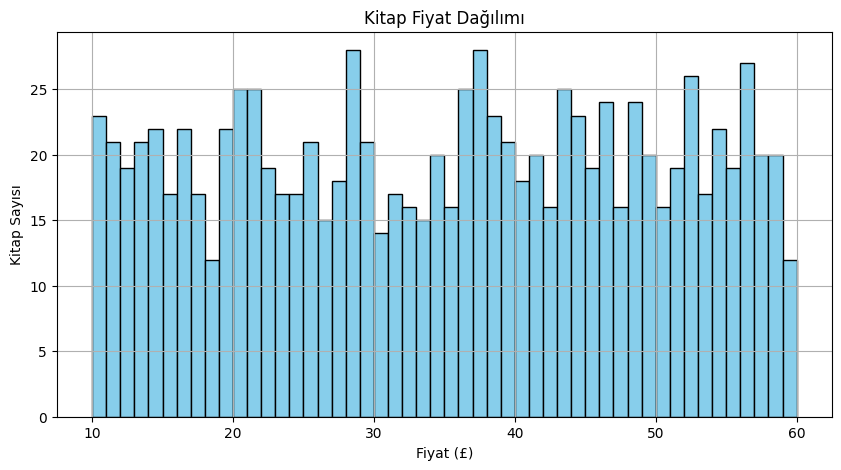

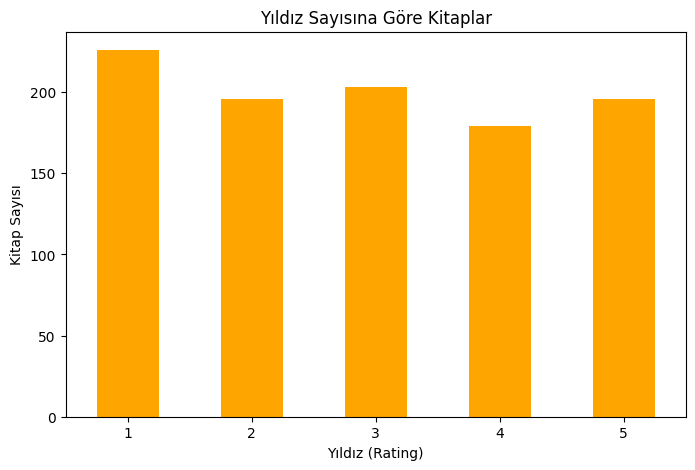

In [15]:
# 1. Fiyat Dağılımı (Histogram)
plt.figure(figsize=(10, 5))
all_books_df["Price"].hist(bins=50, color="skyblue", edgecolor="black")
plt.title("Kitap Fiyat Dağılımı")
plt.xlabel("Fiyat (£)")
plt.ylabel("Kitap Sayısı")
plt.show()

# 2. Yıldız (Rating) Dağılımı (Bar Grafiği)
plt.figure(figsize=(8, 5))
all_books_df["Rating"].value_counts().sort_index().plot(kind="bar", color="orange")
plt.title("Yıldız Sayısına Göre Kitaplar")
plt.xlabel("Yıldız (Rating)")
plt.ylabel("Kitap Sayısı")
plt.xticks(rotation=0)
plt.show()

In [17]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [18]:
# Veriyi CSV olarak kaydet
all_books_df.to_csv("books.csv", index=False)

# Veriyi Excel olarak kaydet (Eğer hata verirse sadece CSV yeterli)
all_books_df.to_excel("books.xlsx", index=False)

print("Dosyalar başarıyla kaydedildi! 💾")

Dosyalar başarıyla kaydedildi! 💾
